In [25]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt 
import torch
import torch.nn as nn 
import torch.nn.functional as F
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
from io import open
from collections import Counter
from functools import partial
import unicodedata
import re
%matplotlib inline

# Process Data

In [2]:
BATCH_SIZE = 32
RESERVED_TOKENS = {'<SOS>': 0, '<EOS>': 1, '<PAD>': 2, '<UNK>': 3}

In [48]:
def text2tokens(raw_text_fp): 
    """ Takes filepath to raw text and outputs a list of lists, each representing a sentence of words (tokens) """
    with open(raw_text_fp) as f:
        tokens_data = [line.lower().split() for line in f.readlines()]       
        tokens_data = [datum + ['<EOS>'] for datum in tokens_data]
    return tokens_data 

def build_vocab(token_lists, max_vocab_size=10000): 
    """ Takes lists of tokens (representing sentences of words) and max_vocab_size and returns: 
        - id2token: list of tokens, where id2token[i] returns token that corresponds to i-th token 
        - token2id: dictionary where keys represent tokens and corresponding values represent their indices
    """
    all_tokens = [token for sublist in token_lists for token in sublist]
    token_counter = Counter(all_tokens)
    vocab, count = zip(*token_counter.most_common(max_vocab_size))
    id2token = list(vocab)
    token2id = dict(zip(vocab, range(len(RESERVED_TOKENS), len(RESERVED_TOKENS)+len(vocab))))
    id2token = list(RESERVED_TOKENS.keys()) + id2token 
    for t in RESERVED_TOKENS: 
        token2id[t] = RESERVED_TOKENS[t]
    return token2id, id2token 

def tokens2indices(tokens_data, token2id): 
    """ Takes tokenized data and token2id dictionary and returns indexed data """
    indices_data = [] 
    for datum in tokens_data: 
        indices_datum = [token2id[token] if token in token2id else RESERVED_TOKENS['<UNK>'] for token in datum ]
        indices_data.append(indices_datum)    
    return indices_data

def get_filepath(split, in_lang, out_lang, order): 
    """ Locates data filepath given data split type (train/dev/test), translation pairs (in_lang -> out_lang), 
        and the order (i.e. whether the file is input or output lang) 
    """
    folder_name = "data/iwslt-{}-{}/".format(in_lang, out_lang)
    if order == 'input': 
        file_name = "{}.tok.{}".format(split, in_lang)
    elif order == 'output': 
        file_name = "{}.tok.{}".format(split, out_lang)
    return folder_name + file_name 

def get_filepaths(in_lang, out_lang): 
    """ Takes language names to be translated from and to (in_lang and out_lang respectively) as inputs, 
        returns a nested dictionary containing the filepaths for input/output data for train/dev/test sets  
    """
    fps = {} 
    for split in ['train', 'dev', 'test']: 
        fps[split] = {} 
        for order in ['input', 'output']: 
            fps[split][order] = {} 
            fps[split][order]['filepath'] = get_filepath(split, in_lang, out_lang, order)
    return fps 
    
def process_data(in_lang, out_lang, in_max_vocab_size=10000, out_max_vocab_size=10000): 
    """ Takes language names to be translated from and to (in_lang and out_lang respectively) as inputs 
        and returns as a nested dictionary containing: 
        - train_indices, val_indices, test_indices (as lists of input-output tuples)
        - train_tokens, val_tokens, test_tokens (as lists of input-output tuples)
        - input language's token2id and id2token 
        - output language's token2id and id2token
    """
    
    # get filepaths 
    data = get_filepaths(in_lang, out_lang)
    data['train']['input']['max_vocab_size'] = in_max_vocab_size
    data['train']['output']['max_vocab_size'] = out_max_vocab_size    
    
    # loop through each file, read in text, convert to tokens, then to indices 
    for split in ['train', 'dev', 'test']: 
        for order in ['input', 'output']: 
            
            # read in tokens 
            data[split][order]['tokens'] = text2tokens(data[split][order]['filepath'])
            
            # build vocab from training data
            if split == 'train': 
                data['train'][order]['token2id'], data['train'][order]['id2token'] = build_vocab(
                    data['train'][order]['tokens'], data['train'][order]['max_vocab_size']) 
                
            # convert tokens to indices 
            data[split][order]['indices'] = tokens2indices(
                data[split][order]['tokens'], data['train'][order]['token2id'])
            
    return data

In [49]:
data = process_data('zh', 'en', in_max_vocab_size=10000, out_max_vocab_size=10000)

In [50]:
data['train']['input']['tokens'][0]

['深海', '海中', '的', '生命', '大卫', '盖罗', '<EOS>']

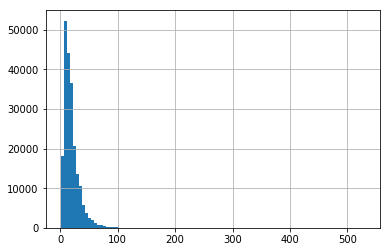

In [51]:
pd.Series(np.array([len(l) for l in data['train']['input']['indices']])).hist(bins=100)

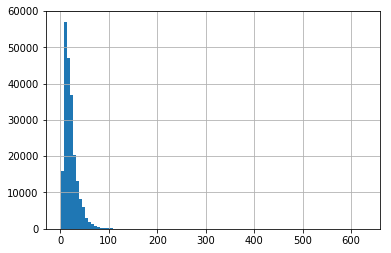

In [52]:
pd.Series(np.array([len(l) for l in data['train']['output']['indices']])).hist(bins=100)

In [53]:
class TranslationDataset(Dataset): 
    """ 
    Class that represents a train/validation/test/dataset that's readable for Pytorch. 
    Note that this class inherits torch.utils.data.Dataset
    """
    def __init__(self, input_list, output_list, max_sentence_len_in, max_sentence_len_out):
        """ 
        Initialize dataset by passing in a list of input indices and a list of output indices 
        """
        self.input_list = input_list
        self.output_list = output_list
        self.max_sentence_len_in = max_sentence_len_in
        self.max_sentence_len_out = max_sentence_len_out
        assert (len(self.input_list) == len(self.output_list))
        
    def __len__(self): 
        return len(self.input_list)
    
    def __getitem__(self, key): 
        """ 
        Triggered when dataset[i] is called, outputs lists of input and output indices, as well as their 
        respective lengths
        """
        in_idx = self.input_list[key][:self.max_sentence_len_in]
        in_len = len(in_idx)
        out_idx = self.output_list[key][:self.max_sentence_len_out]
        out_len = len(out_idx)
        return [in_idx, out_idx, in_len, out_len]
    
def collate_func(max_sentence_len_in, max_sentence_len_out, batch): 
    """ Customized function for DataLoader that dynamically pads the batch so that all data have the same length"""
    
    in_idxs = [] 
    out_idxs = [] 
    in_lens = [] 
    out_lens = [] 
    
    for datum in batch: 
        # append original lengths of sequences 
        in_lens.append(datum[2]) 
        out_lens.append(datum[3])
        
        # pad sequences before appending 
        in_idx_padded = np.pad(array=np.array(datum[0]), pad_width = ((0, max_sentence_len_in - datum[2])), 
                               mode='constant', constant_values= 0)
        out_idx_padded = np.pad(array=np.array(datum[1]), pad_width = ((0, max_sentence_len_out - datum[3])), 
                                mode='constant', constant_values= 0)
        in_idxs.append(in_idx_padded)
        out_idxs.append(out_idx_padded)
    
    return [torch.from_numpy(np.array(in_idxs)), torch.from_numpy(np.array(out_idxs)), 
            torch.LongTensor(in_lens), torch.LongTensor(out_lens)]

def create_dataloaders(processed_data, max_sentence_len_in, max_sentence_len_out): 
    """ Takes processed_data as dictionary output from process_data func, maximum sentence lengths, 
        and outputs train_loader, dev_loader, and test_loaders 
    """
    loaders = {} 
    for split in ['train', 'dev', 'test']: 
        dataset = TranslationDataset(data[split]['input']['indices'], data[split]['output']['indices'], 
                                     max_sentence_len_in, max_sentence_len_out)
        loaders[split] = DataLoader(dataset, batch_size=BATCH_SIZE, shuffle=False, 
                                    collate_fn=partial(collate_func, max_sentence_len_in, max_sentence_len_out))
    return loaders['train'], loaders['dev'], loaders['test']

In [54]:
MAX_SENTENCE_LEN_IN = 20 
MAX_SENTENCE_LEN_OUT = 20
data = process_data('zh', 'en', in_max_vocab_size=10000, out_max_vocab_size=10000)
train_loader, dev_loader, test_loader = create_dataloaders(data, MAX_SENTENCE_LEN_IN, MAX_SENTENCE_LEN_OUT)

In [58]:
for i, (in_idxs, out_idxs, in_lens, out_lens) in enumerate(train_loader):
    print(i)
    print(in_idxs.size())
    print(in_idxs)
    print(in_lens)
    break 

0
torch.Size([32, 20])
tensor([[3811, 3500,    4,  206, 1762,    3,    1,    0,    0,    0,    0,    0,
            0,    0,    0,    0,    0,    0,    0,    0],
        [1762,    3,  125, 2375,    3, 4962,    4, 2103,   40,    8, 1696,   10,
          296,  119, 2033,  119,    3,  199,   24, 4378],
        [1762,    3, 1190,    7, 2315,    3,    6,    7, 1762,    3,    1,    0,
            0,    0,    0,    0,    0,    0,    0,    0],
        [   8,   53,   85,   68, 2103, 2008,  836,   68, 3811, 3439,    4,  147,
            1,    0,    0,    0,    0,    0,    0,    0],
        [   8,   12,   16, 2592, 2270,    4,    3,    3,    3, 3523,    4, 2103,
         5333,  984,  196, 1947,  474,    1,    0,    0],
        [   3,    3,    3,    3, 3523, 1346,    7,  625,   10, 2592,    3, 5019,
           37,  143,  211,   17,   72,   56,  145,    3],
        [ 287,  487,    8,  231,  394,   40,  612,    3, 1993,    3, 2995,    1,
            0,    0,    0,    0,    0,    0,    0,    0],
    